In [ ]:
import sys
import os
import glob
import random
import time
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import re

Global Variable

In [ ]:
# Path to all data
DATA_PATH = "./dataset/kaggle_3m/"

# File path line length images for later sorting
BASE_LEN = 89 
END_IMG_LEN = 4
END_MASK_LEN = 9

# img size
IMG_SIZE = 512

# Data

## Creating a DataFrame

In [ ]:
# Raw data
data_map = []
for sub_dir_path in glob.glob(DATA_PATH+"*"):
    if os.path.isdir(sub_dir_path):
        dirname = sub_dir_path.split("/")[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + "/" + filename
            data_map.extend([dirname, image_path])
    else:
        print("This is not a dir:", sub_dir_path)
        
        
df = pd.DataFrame({"dirname" : data_map[::2],
                  "path" : data_map[1::2]})

def extract_slice_number(path):
    # 修改正则表达式以匹配包含 _mask 的文件名
    match = re.search(r"_(\d+)_mask\.tif|_(\d+)\.tif", path)
    if match:
        return int(match.group(1) or match.group(2))  # 兼容带 _mask 和不带 _mask 的文件
    else:
        raise ValueError(f"Can not extract: {path}")


df.head()

In [ ]:
# Masks/Not masks
df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]


# # 排序图像和掩码路径
imgs = sorted(df_imgs["path"].values, key=lambda x: extract_slice_number(x))
masks = sorted(df_masks["path"].values, key=lambda x: extract_slice_number(x))

# # 验证排序
idx = random.randint(0, len(imgs)-1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])


Final dataframe

In [ ]:
# Final dataframe
df = pd.DataFrame({"patient": df_imgs.dirname.values,
                       "image_path": imgs,
                   "mask_path": masks})


# Adding A/B column for diagnosis
def positiv_negativ_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : return 1
    else: return 0

df["diagnosis"] = df["mask_path"].apply(lambda m: positiv_negativ_diagnosis(m))
df

## Data Distribution

Distribution of positive/negative diagnosis

In [ ]:
# Plot
ax = df.diagnosis.value_counts().plot(kind='bar',
                                      stacked=True,
                                      figsize=(10, 6),
                                     color=["violet", "lightseagreen"])


ax.set_xticklabels(["Positive", "Negative"], rotation=45, fontsize=12);
ax.set_ylabel('Total Images', fontsize = 12)
ax.set_title("Distribution of data grouped by diagnosis",fontsize = 18, y=1.05)

# Annotate
for i, rows in enumerate(df.diagnosis.value_counts().values):
    ax.annotate(int(rows), xy=(i, rows-12), 
                rotation=0, color="white", 
                ha="center", verticalalignment='bottom', 
                fontsize=15, fontweight="bold")
    
ax.text(1.2, 2550, f"Total {len(df)} images", size=15,
        color="black",
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   fc=("lightblue"),
                   ec=("black"),
                   )
         );

Distribution of positive/negative diagnosis between each patient

In [ ]:
# Data
patients_by_diagnosis = df.groupby(['patient', 'diagnosis'])['diagnosis'].size().unstack().fillna(0)
patients_by_diagnosis.columns = ["Positive", "Negative"]

# Plot
ax = patients_by_diagnosis.plot(kind='bar',stacked=True,
                                figsize=(18, 10),
                                color=["mediumvioletred", "springgreen"], 
                                alpha=0.9)
ax.legend(fontsize=20);
ax.set_xlabel('Patients',fontsize = 20)
ax.set_ylabel('Total Images', fontsize = 20)
ax.set_title("Distribution of data grouped by patient and diagnosis",fontsize = 25, y=1.005)

# Annotations
"""for i, rows in enumerate(patients_by_diagnosis.values):
    plt.annotate(int(rows[0]), xy=(i, rows[0]+1), rotation=90, color="white")
    plt.annotate(int(rows[1]), xy=(i, rows[1]+1), rotation=90, color="aqua")""";

## Data Visualization

Samples of images with a positive and negative diagnosis

In [ ]:
# Data
sample_yes_df = df[df["diagnosis"] == 1].sample(5).image_path.values
sample_no_df = df[df["diagnosis"] == 0].sample(5).image_path.values

sample_imgs = []
for i, (yes, no) in enumerate(zip(sample_yes_df, sample_no_df)):
    yes = cv2.resize(cv2.imread(yes), (IMG_SIZE, IMG_SIZE))
    no = cv2.resize(cv2.imread(no), (IMG_SIZE, IMG_SIZE))
    sample_imgs.extend([yes, no])


sample_yes_arr = np.vstack(np.array(sample_imgs[::2]))
sample_no_arr = np.vstack(np.array(sample_imgs[1::2]))

# Plot
fig = plt.figure(figsize=(25., 25.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 4),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )


grid[0].imshow(sample_yes_arr)
grid[0].set_title("Positive", fontsize=15)
grid[0].axis("off")
grid[1].imshow(sample_no_arr)
grid[1].set_title("Negative", fontsize=15)
grid[1].axis("off")

grid[2].imshow(sample_yes_arr[:,:,0], cmap="hot")
grid[2].set_title("Positive", fontsize=15)
grid[2].axis("off")
grid[3].imshow(sample_no_arr[:,:,0], cmap="hot")
grid[3].set_title("Negative", fontsize=15)
grid[3].axis("off")#set_title("No", fontsize=15)

# annotations
plt.figtext(0.36,0.90,"Original", va="center", ha="center", size=20)
plt.figtext(0.66,0.90,"With hot colormap", va="center", ha="center", size=20)
plt.suptitle("Brain MRI Images for Brain Tumor Detection\nLGG Segmentation Dataset", y=.95, fontsize=30, weight="bold")

# save and show
plt.savefig("dataset.png", bbox_inches='tight', pad_inches=0.2, transparent=True)
plt.show()

## Data Preparation

In [ ]:
import os
import cv2
import numpy as np
from PIL import Image

data_path = "./dataset/kaggle_3m/"  
output_slices_path = "./output/slices/"  
os.makedirs(output_slices_path, exist_ok=True)

for patient_folder in os.listdir(data_path):
    patient_path = os.path.join(data_path, patient_folder)
    if not os.path.isdir(patient_path):
        continue  
    for file_name in os.listdir(patient_path):
        if file_name.endswith(".tif") and not file_name.endswith("_mask.tif"):
            # Load 3 chanels MRI images
            file_path = os.path.join(patient_path, file_name)
            image = np.array(Image.open(file_path))  

            # save as png format
            slice_output_path = os.path.join(output_slices_path, file_name.replace(".tif", ".png"))
            cv2.imwrite(slice_output_path, image)
            print(f"Saved slice: {slice_output_path}")

In [ ]:
import json
from PIL import Image

mask_path = "./dataset/kaggle_3m/"  
output_annotations_path = "./output/annotations.json"  

annotations = []
image_id = 0 

for patient_folder in os.listdir(mask_path):
    patient_folder_path = os.path.join(mask_path, patient_folder)
    if not os.path.isdir(patient_folder_path):
        continue  # Skip Non-Folder
    
    for file_name in os.listdir(patient_folder_path):
        if file_name.endswith("_mask.tif"):  # 匹配掩码文件
            # 加载掩码
            mask_file_path = os.path.join(patient_folder_path, file_name)
            mask = np.array(Image.open(mask_file_path))  # 加载为 NumPy 数组
            # 获取边界框
            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            bboxes = []
            for contour in contours:
                x, y, w, h = cv2.boundingRect(contour)
                bboxes.append({"x_min": x, "y_min": y, "x_max": x + w, "y_max": y + h})
            if bboxes: 
                # add anotation of COCO format
                annotations.append({
                    "image_id": image_id,
                    "file_name": file_name.replace("_mask.tif", ".png"),  # 对应的图像文件名
                    "bboxes": bboxes,
                    "category": "LGG"
                })
                
                image_id += 1

with open(output_annotations_path, "w") as f:
    json.dump(annotations, f, indent=4)
print(f"Annotations saved to {output_annotations_path}")

## Tasks Implementation

### Split Data

In [ ]:
import json
from sklearn.model_selection import train_test_split

# Load COCO annotations
with open('./output/annotations.json', 'r') as f:
    annotations = json.load(f)

# Split dataset
train_data, temp_data = train_test_split(annotations, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.33, random_state=42)  # 20% val, 10% test

# Save split annotations
with open('./output/train_annotations.json', 'w') as f:
    json.dump(train_data, f)
with open('./output/val_annotations.json', 'w') as f:
    json.dump(val_data, f)
with open('./output/test_annotations.json', 'w') as f:
    json.dump(test_data, f)

### Dataset Class

In [ ]:
import os
import torch
from PIL import Image
from torchvision.transforms import functional as F

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, annotations_file, images_dir, transforms=None):
        with open(annotations_file, 'r') as f:
            self.annotations = json.load(f)
        self.images_dir = images_dir
        self.transforms = transforms

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        data = self.annotations[idx]
        image_path = os.path.join(self.images_dir, data['file_name'])
        image = Image.open(image_path).convert("RGB") 
        
        if self.transforms:
            image = self.transforms(image)
        else:
            image = F.to_tensor(image)

        bboxes = data['bboxes']
        boxes = []
        for bbox in bboxes:
            boxes.append([bbox['x_min'], bbox['y_min'], bbox['x_max'], bbox['y_max']])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((len(bboxes),), dtype=torch.int64)  

        target = {"boxes": boxes, "labels": labels}

        return image, target

### Data Augmentation

In [ ]:
from torchvision import transforms

# Define transformations
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
])

### Load Data

In [ ]:
from torch.utils.data import DataLoader

# Dataset directories
images_dir = "./output/slices/"

def collate_fn(batch):
    filtered_batch = []
    for item in batch:
        try:
            filtered_batch.append(item)
        except ValueError as e:
            print(e)  # Log the error for debugging
    if len(filtered_batch) == 0:
        raise ValueError("All samples in the batch are invalid.")
    return tuple(zip(*filtered_batch))
# Create datasets
train_dataset = CustomDataset('./output/train_annotations.json', images_dir, transforms=data_transforms)
val_dataset = CustomDataset('./output/val_annotations.json', images_dir, transforms=None)
test_dataset = CustomDataset('./output/test_annotations.json', images_dir, transforms=None)


# 在 DataLoader custom collate_fn
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)




In [ ]:
# no_bboxes_count = 0
# for data in annotations:
#     if len(data['bboxes']) == 0:
#         no_bboxes_count += 1
#         print(f"No bounding boxes found for image {data['file_name']}")

# print(f"Total images without bounding boxes: {no_bboxes_count}")

## Load Pre-trained Faster R-CNN

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Load Faster R-CNN pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=True)

# Modify the box predictor to match our dataset (1 class + background)
num_classes = 2   # 1 (LGG) + 1 (background)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

### Train and Evaluate

In [ ]:
from tqdm import tqdm

def train_one_epoch(model, dataloader, optimizer, device="cpu"):
    """
    Train the Faster R-CNN model for one epoch.

    Args:
        model (torch.nn.Module): Faster R-CNN model to train.
        dataloader (torch.utils.data.DataLoader): DataLoader for training data.
        optimizer (torch.optim.Optimizer): Optimizer for training.
        device (str or torch.device): Device to run the training on (default "cpu").

    Returns:
        float: Average training loss for the epoch.
    """
    model.train()  # Set the model to training mode
    total_loss = 0  # Track total loss
    for images, targets in tqdm(dataloader, desc="Training"):
        # Move data to device
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        # Forward pass and compute loss
        loss_dict = model(images, targets)  # Loss dictionary
        loss = sum(loss for loss in loss_dict.values())  # Total loss
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()  # Accumulate loss
    # Compute average loss
    average_loss = total_loss / len(dataloader)
    # print(f"Training Loss: {average_loss:.4f}")
    return average_loss



from tqdm import tqdm

def evaluate_manual_mAP(model, dataloader, device="cpu"):
    """
    Evaluate the Faster R-CNN model on the validation set and compute mAP manually.
    Args:
        model (torch.nn.Module): Faster R-CNN model to evaluate.
        dataloader (torch.utils.data.DataLoader): DataLoader for validation data.
        device (str or torch.device): Device to run the evaluation on (default "cpu").
    Returns:
        dict: Simplified metrics including mAP, precision, and recall.
    """
    model.eval()  # Set model to evaluation mode
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc="Evaluating"):
            # Move data to device
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            # Forward pass to get predictions
            outputs = model(images)
            # Store predictions and targets
            all_predictions.extend(outputs)
            all_targets.extend(targets)

    # Compute mAP manually (example implementation)
    metrics = compute_metrics(all_predictions, all_targets)
    # print(f"Validation - mAP: {metrics['map']:.4f}, Precision: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}")
    return metrics

def compute_metrics(predictions, targets, iou_threshold=0.5):
    """
    Simplified mAP calculation for object detection.
    Args:
        predictions (list): List of predictions (output from the model).
        targets (list): List of ground truth annotations.
        iou_threshold (float): IOU threshold for true positives.

    Returns:
        dict: Dictionary containing mAP, precision, and recall.
    """
    tp, fp, fn = 0, 0, 0

    for pred, target in zip(predictions, targets):
        pred_boxes = pred['boxes'].cpu().numpy()
        target_boxes = target['boxes'].cpu().numpy()

        # Track matched ground truth boxes
        matched_gt = set()

        # Match predictions with targets
        for pb in pred_boxes:
            matched = False
            for idx, tb in enumerate(target_boxes):
                if idx not in matched_gt and compute_iou(pb, tb) >= iou_threshold:
                    tp += 1
                    matched_gt.add(idx)  # Mark this ground truth as matched
                    matched = True
                    break
            if not matched:
                fp += 1  # Prediction did not match any ground truth
        # Calculate FN for this image
        fn += len(target_boxes) - len(matched_gt)

    # Calculate precision and recall
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    map_score = (precision + recall) / 2  # Simplified mAP

    return {"map": map_score, "precision": precision, "recall": recall}


def compute_iou(box1, box2):
    """
    Compute Intersection over Union (IoU) between two bounding boxes.

    Args:
        box1 (array): First bounding box [x_min, y_min, x_max, y_max].
        box2 (array): Second bounding box [x_min, y_min, x_max, y_max].

    Returns:
        float: IoU value.
    """
    x_min = max(box1[0], box2[0])
    y_min = max(box1[1], box2[1])
    x_max = min(box1[2], box2[2])
    y_max = min(box1[3], box2[3])

    inter_area = max(0, x_max - x_min) * max(0, y_max - y_min)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - inter_area

    return inter_area / union_area if union_area > 0 else 0


from tqdm import tqdm

def test(model, dataloader, device="cpu"):
    """
    Test the Faster R-CNN model on the test set and return predictions.

    Args:
        model (torch.nn.Module): Faster R-CNN model to test.
        dataloader (torch.utils.data.DataLoader): DataLoader for test data.
        device (str or torch.device): Device to run the testing on (default "cpu").

    Returns:
        list: List of predictions for each image in the test set.
    """
    model.eval()  # Set model to evaluation mode
    predictions = []  # Store predictions

    with torch.no_grad():
        for images, _ in tqdm(dataloader, desc="Testing"):
            # Move images to device
            images = [img.to(device) for img in images]

            # Forward pass to get predictions
            outputs = model(images)
            predictions.extend(outputs)

    return predictions


In [ ]:
import torch
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn

device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')
model = fasterrcnn_resnet50_fpn(weights=True).to(device)
optimizer = AdamW(model.parameters(), lr=0.0001, weight_decay=0.0001)

num_epochs = 200
train_loss_history = []
val_mAP_history=[]
val_precis_history=[]
val_recall_history=[]
best_map=-1

# Training
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train_loss = train_one_epoch(model, train_loader, optimizer, device)
    train_loss_history.append(train_loss)
    print(f"Epoch {epoch + 1} Training Loss: {train_loss:.4f}")    
    # Replace evaluate with evaluate_manual_mAP
    metrics = evaluate_manual_mAP(model, val_loader, device)
    val_mAP_history.append(metrics['map'])
    val_precis_history.append(metrics['precision'])
    val_recall_history.append(metrics['recall'])
    # Check for improvement in mAP
    if metrics['map'] > best_map:
        best_map = metrics['map']
        print(f"Validation - mAP: {metrics['map']:.4f}, Precision: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}")
        print("New best mAP achieved! Saving model.")
        # Save the model state if mAP improves
        torch.save(model.state_dict(), 'best_model.pth')


In [ ]:
train_loss_history,val_mAP_history,val_precis_history,val_recall_history

In [ ]:
import matplotlib.pyplot as plt

def plot_history(train_loss_history):
    """
    Args:
        train_loss_history (list): 训练损失记录。
        val_loss_history (list): 验证损失记录。
    """
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss_history, label="Training Loss", marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_history(train_loss_history)


In [ ]:
import matplotlib.pyplot as plt

def plot_history(val_mAP_history,val_precis_history,val_recall_history):
    """
    Args:

    """
    plt.figure(figsize=(10, 6))
    plt.plot(val_mAP_history, label="Validation mAP", marker='o')
    plt.plot(val_precis_history, label="Precision mAP", marker='o')
    plt.plot(val_recall_history, label="Recall mAP", marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Percentage")
    plt.title("Percentage Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_history(val_mAP_history,val_precis_history,val_recall_history)




## Result Visualization

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_predictions_with_targets(image, targets, outputs, score_threshold=0.5, save_path=None):
    """
    Visualize the predictions and ground truth boxes on a single image, with optional saving functionality.
    
    Args:
        image (torch.Tensor): The input image tensor.
        targets (dict): Ground truth annotations (e.g., boxes, labels).
        outputs (dict): Predictions from the model.
        score_threshold (float): Minimum score for displaying predictions.
        save_path (str, optional): Path to save the visualization image. If None, the image is not saved.
    """
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image.permute(1, 2, 0).cpu().numpy())  # Display the image

    # Plot ground truth boxes (in green)
    print("Truth Result")
    for box in targets['boxes']:
        x_min, y_min, x_max, y_max = box.tolist()
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                                  linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
        ax.text(x_min, y_min, "GT", color="green", fontsize=10)  # GT for ground truth

    # Plot predicted boxes (in red)
    print("Predicted Result")
    for box, score, label in zip(outputs['boxes'], outputs['scores'], outputs['labels']):
        if score > score_threshold:  # Filter by confidence score
            x_min, y_min, x_max, y_max = box.tolist()
            rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                                      linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(x_min, y_min, f"Pred {label.item()} ({score:.2f})", color="red", fontsize=10)

    plt.axis('off')  # Hide axes
    
    # Save the figure if save_path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        print(f"Image saved to {save_path}")
    
    plt.show()

import os
import torch
from PIL import Image
from torchvision.transforms import functional as F

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, annotations_file, images_dir, transforms=None):
        with open(annotations_file, 'r') as f:
            self.annotations = json.load(f)
        self.images_dir = images_dir
        self.transforms = transforms

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        data = self.annotations[idx]
        image_path = os.path.join(self.images_dir, data['file_name'])
        image = Image.open(image_path).convert("RGB") 
        
        if self.transforms:
            image = self.transforms(image)
        else:
            image = F.to_tensor(image)

        bboxes = data['bboxes']
        boxes = []
        for bbox in bboxes:
            boxes.append([bbox['x_min'], bbox['y_min'], bbox['x_max'], bbox['y_max']])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((len(bboxes),), dtype=torch.int64)  

        target = {"boxes": boxes, "labels": labels}

        return image, target

In [2]:
import torch
from torch.utils.data import DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn

device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
import json
from sklearn.model_selection import train_test_split

# Load COCO annotations
with open('./output/annotations.json', 'r') as f:
    annotations = json.load(f)

# Split dataset
train_data, temp_data = train_test_split(annotations, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.33, random_state=42)  # 20% val, 10% test

# Save split annotations
with open('./output/train_annotations.json', 'w') as f:
    json.dump(train_data, f)
with open('./output/val_annotations.json', 'w') as f:
    json.dump(val_data, f)
with open('./output/test_annotations.json', 'w') as f:
    json.dump(test_data, f)

from torch.utils.data import DataLoader

# Dataset directories
images_dir = "./output/slices/"

def collate_fn(batch):
    filtered_batch = []
    for item in batch:
        try:
            filtered_batch.append(item)
        except ValueError as e:
            print(e)  # Log the error for debugging
    if len(filtered_batch) == 0:
        raise ValueError("All samples in the batch are invalid.")
    return tuple(zip(*filtered_batch))

test_dataset = CustomDataset('./output/test_annotations.json', images_dir, transforms=None)

test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

from tqdm import tqdm

def test(model, dataloader, device="cpu"):
    """
    Test the Faster R-CNN model on the test set and return predictions.

    Args:
        model (torch.nn.Module): Faster R-CNN model to test.
        dataloader (torch.utils.data.DataLoader): DataLoader for test data.
        device (str or torch.device): Device to run the testing on (default "cpu").

    Returns:
        list: List of predictions for each image in the test set.
    """
    model.eval()  # Set model to evaluation mode
    predictions = []  # Store predictions

    with torch.no_grad():
        for images, _ in tqdm(dataloader, desc="Testing"):
            # Move images to device
            images = [img.to(device) for img in images]

            # Forward pass to get predictions
            outputs = model(images)
            predictions.extend(outputs)

    return predictions



In [4]:


model = fasterrcnn_resnet50_fpn(weights=True).to(device)

checkpoint_path = 'best_model.pth'  # 你的模型参数保存路径
model.load_state_dict(torch.load(checkpoint_path, map_location=device))

model.eval()

test_predictions = test(model, test_loader, device)

file_path = "./output/results/"
os.makedirs(file_path, exist_ok=True)  # 确保目录存在，如果不存在则创建

# for idx, (images, targets) in enumerate(test_loader):
#     images = [img.to(device) for img in images]
#     outputs = model(images)  # 预测结果

#     # 保存文件路径，文件名以索引命名，例如 result_0.png
#     save_path = os.path.join(file_path, f"result_{idx}.png")

#     visualize_predictions_with_targets(
#         image=images[0], 
#         targets=targets[0], 
#         outputs=outputs[0],
#         score_threshold=0.3,
#         save_path=save_path  # 保存路径传递给函数
#     )

/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_384469/926683598.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be 

Grid image saved to ./output/results/grid_visualization.png


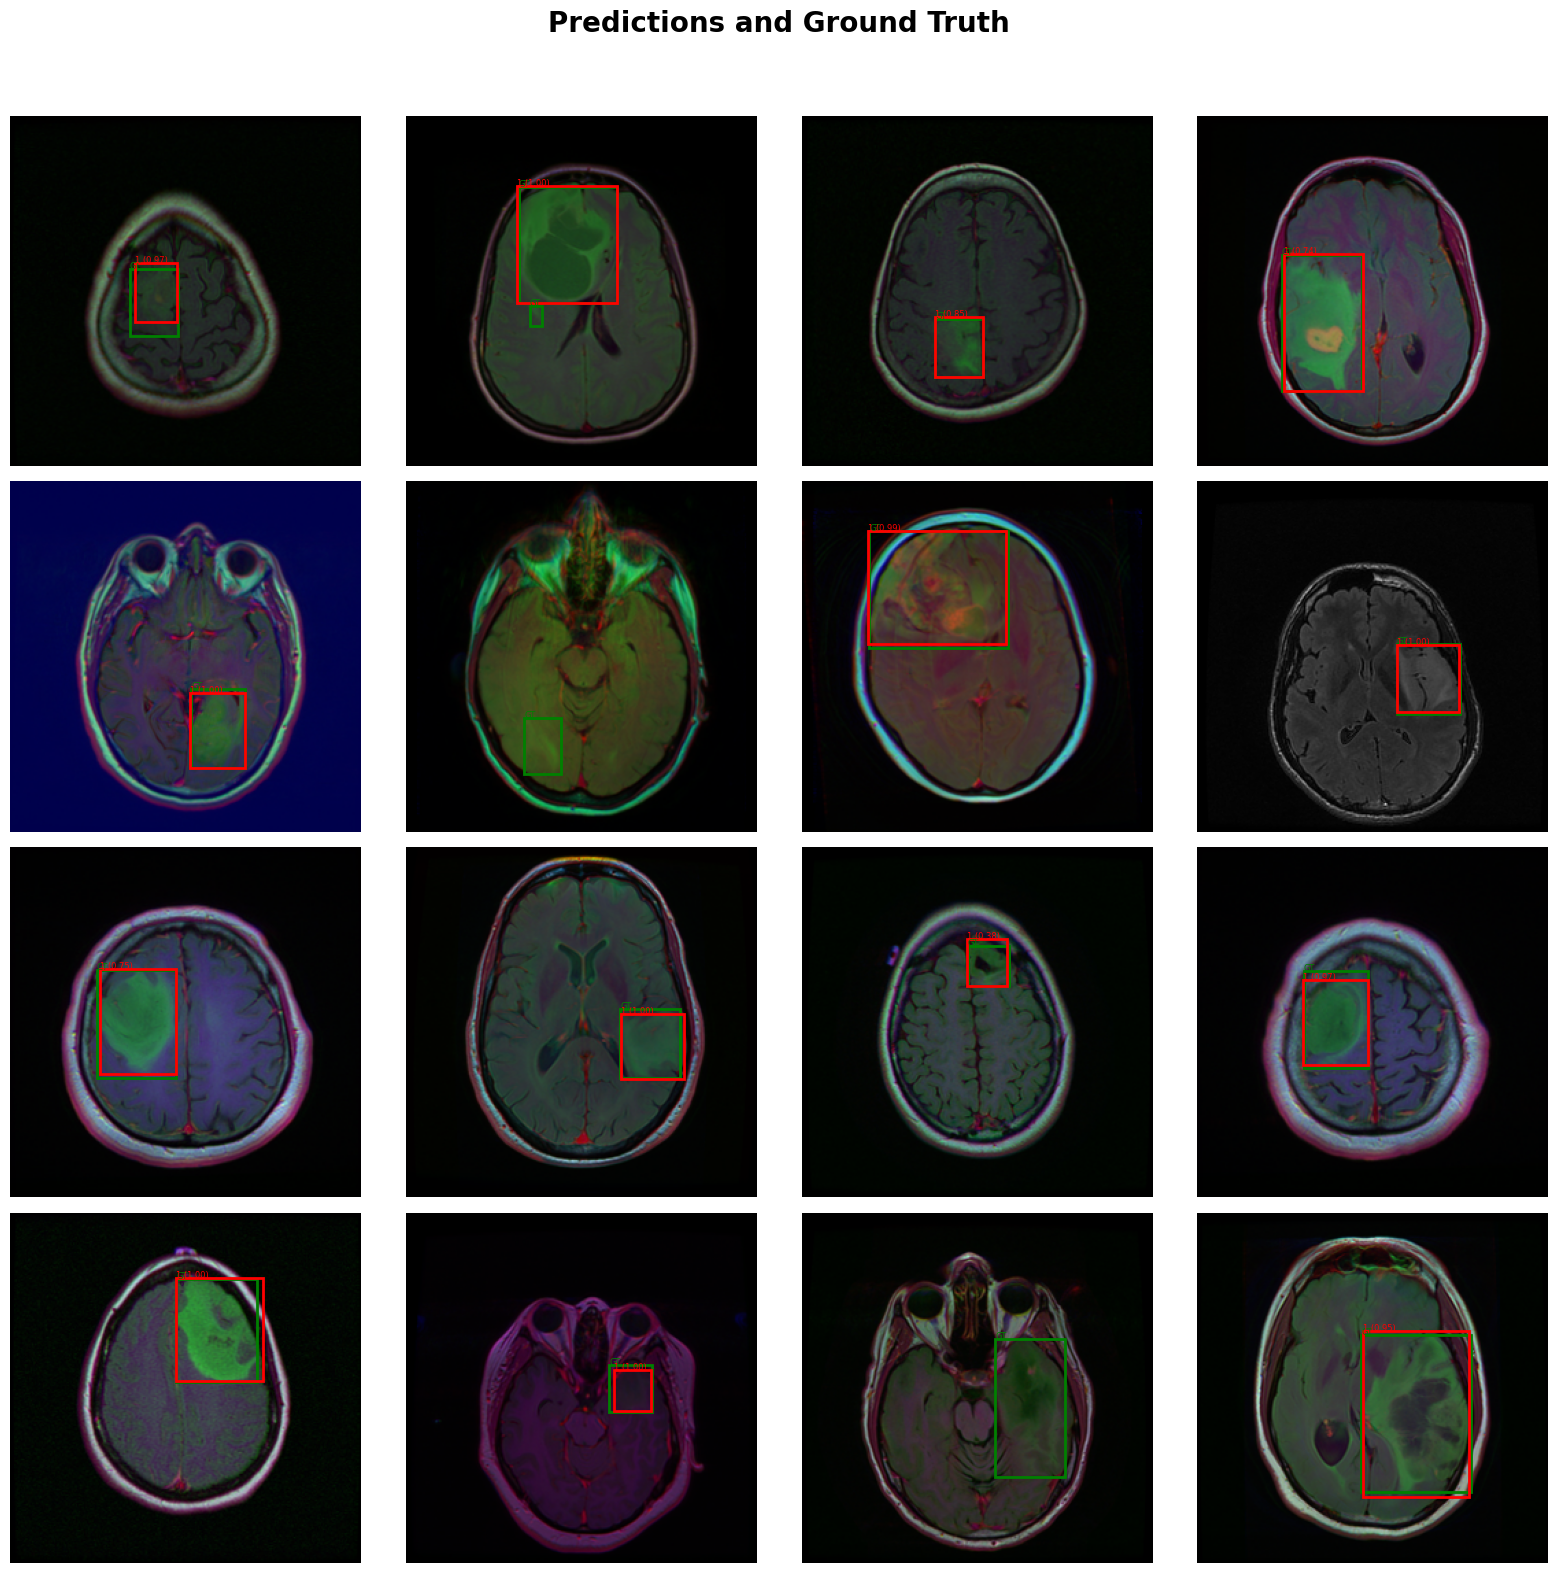

In [7]:
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_grid_predictions(images, targets_list, outputs_list, score_threshold=0.5, save_path=None, title=None):
    """
    Visualize the predictions and ground truth boxes on a grid of images, with optional title.
    
    Args:
        images (list[torch.Tensor]): List of input image tensors.
        targets_list (list[dict]): List of ground truth annotations (e.g., boxes, labels).
        outputs_list (list[dict]): List of predictions from the model.
        score_threshold (float): Minimum score for displaying predictions.
        save_path (str, optional): Path to save the visualization image. If None, the image is not saved.
        title (str, optional): Title for the visualization grid.
    """
    num_images = len(images)
    grid_size = int(num_images**0.5)  # Assuming square grid
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(16, 16))
    
    if title:
        fig.suptitle(title, fontsize=20, weight='bold')  # Add a title to the figure

    for i, (image, targets, outputs) in enumerate(zip(images, targets_list, outputs_list)):
        ax = axes[i // grid_size, i % grid_size]  # Get subplot
        ax.imshow(image.permute(1, 2, 0).cpu().numpy())  # Display the image

        # Plot ground truth boxes (in green)
        for box in targets['boxes']:
            x_min, y_min, x_max, y_max = box.tolist()
            rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                      linewidth=2, edgecolor='g', facecolor='none')
            ax.add_patch(rect)
            ax.text(x_min, y_min, "GT", color="green", fontsize=6)  # GT for ground truth

        # Plot predicted boxes (in red)
        for box, score, label in zip(outputs['boxes'], outputs['scores'], outputs['labels']):
            if score > score_threshold:  # Filter by confidence score
                x_min, y_min, x_max, y_max = box.tolist()
                rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                          linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
                ax.text(x_min, y_min, f"{label.item()} ({score:.2f})", color="red", fontsize=6)

        ax.axis('off')  # Hide axes

    # Remove empty subplots if num_images < grid_size^2
    for i in range(num_images, grid_size * grid_size):
        axes[i // grid_size, i % grid_size].axis('off')

    # Adjust layout to accommodate title
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Save the figure if save_path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        print(f"Grid image saved to {save_path}")
    
    plt.show()

# 处理前 16 张图像
file_path = "./output/results/"
os.makedirs(file_path, exist_ok=True)  # 确保目录存在

images_batch = []
targets_batch = []
outputs_batch = []
batch_limit = 16  # 限制为前 16 张

for idx, (images, targets) in enumerate(test_loader):
    images = [img.to(device) for img in images]
    outputs = model(images)  # 获取预测结果

    for img, target, output in zip(images, targets, outputs):
        if len(images_batch) < batch_limit:
            images_batch.append(img)
            targets_batch.append(target)
            outputs_batch.append(output)
        else:
            break
    if len(images_batch) >= batch_limit:
        break

save_path = os.path.join(file_path, "grid_visualization.png")
visualize_grid_predictions(
    images=images_batch,
    targets_list=targets_batch,
    outputs_list=outputs_batch,
    score_threshold=0.3,
    save_path=save_path,
    title="Predictions and Ground Truth" 
)